In [1]:
import dlib 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
#datasets 공유폴더에서 이미지, 모델 2 다운 
#prompt에서 conda install -c conda-forge dlib 다운

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor('./models/shape_predictor_5_face_landmarks.dat') #dlib에서 배포하는 모델로 , 얼굴에 다섯개의 랜드마크를 찾아주는 모델 

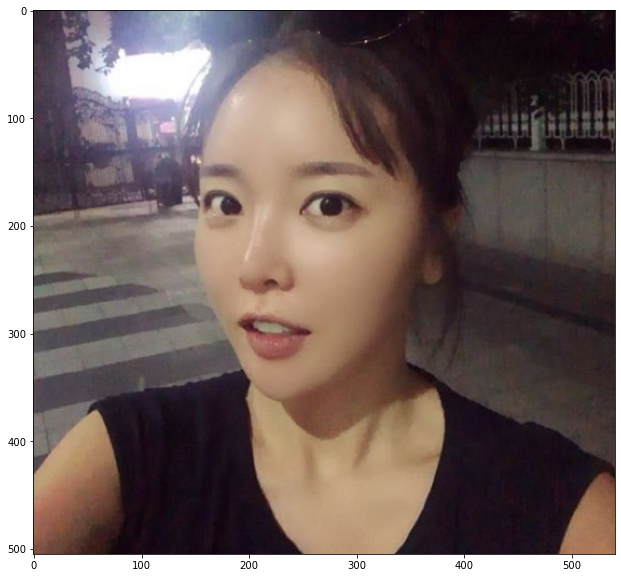

In [3]:
img = dlib.load_rgb_image('./imgs/12.jpg')
plt.figure(figsize=(16,10))
plt.imshow(img)
plt.show()

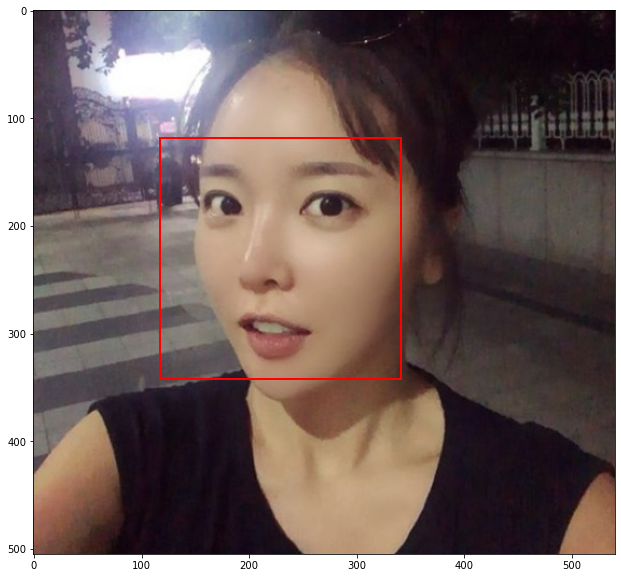

In [4]:
#얼굴 영역만 찾기
img_result = img.copy()
dets = detector(img, 1)
if len(dets) == 0: #사진에 얼굴이 없는 경우
    print('cannot find faces!')
else:
    fig,ax = plt.subplots(1, figsize=(16,10)) #한줄
    for det in dets: #dets 에는 얼굴의 영역들이 들어있고 왼쪽 맨 위를 원점의 x,y 좌표와 영역의 폭과 높이에 대한 정보를 가지고 있음
        x,y,w,h = det.left(),det.top(),det.width(),det.height()
        rect = patches.Rectangle((x,y),w,h,linewidth=2, edgecolor='r', facecolor='none') #facecolor 에 색을 넣으면 영역 안을 색으로 채워줌
        ax.add_patch(rect) #사각형을 띄워줌
    ax.imshow(img_result)
    plt.show()


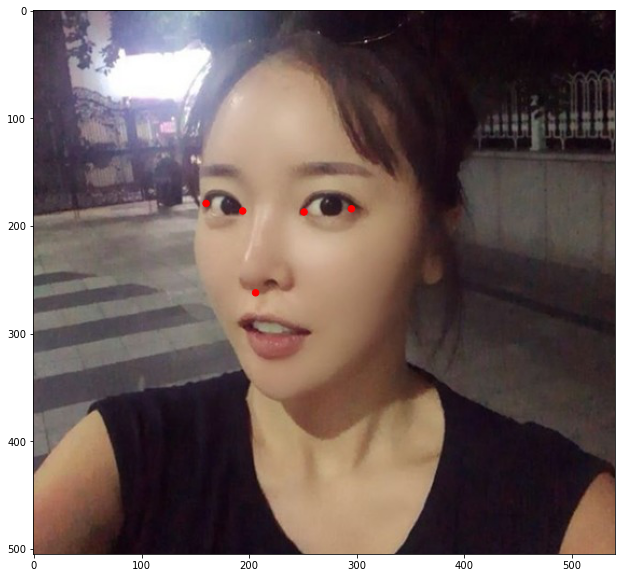

In [5]:
fig, ax = plt.subplots(1,figsize=(16,10)) #fig 도화지, ax 서브플랏들 
objs = dlib.full_object_detections() #얼굴이 돌려졌을 때 똑바로 돌려주는 메서드 
for detection in dets:
    s = sp(img, detection) #sp : 모양을 예측해줌    원본이미지 와 얼굴 영역 정보 부여 (사각형 X)
    objs.append(s)
    for point in s.parts():
        circle = patches.Circle((point.x,point.y), radius=3,edgecolor='r',facecolor='r')
        ax.add_patch(circle)
ax.imshow(img_result)

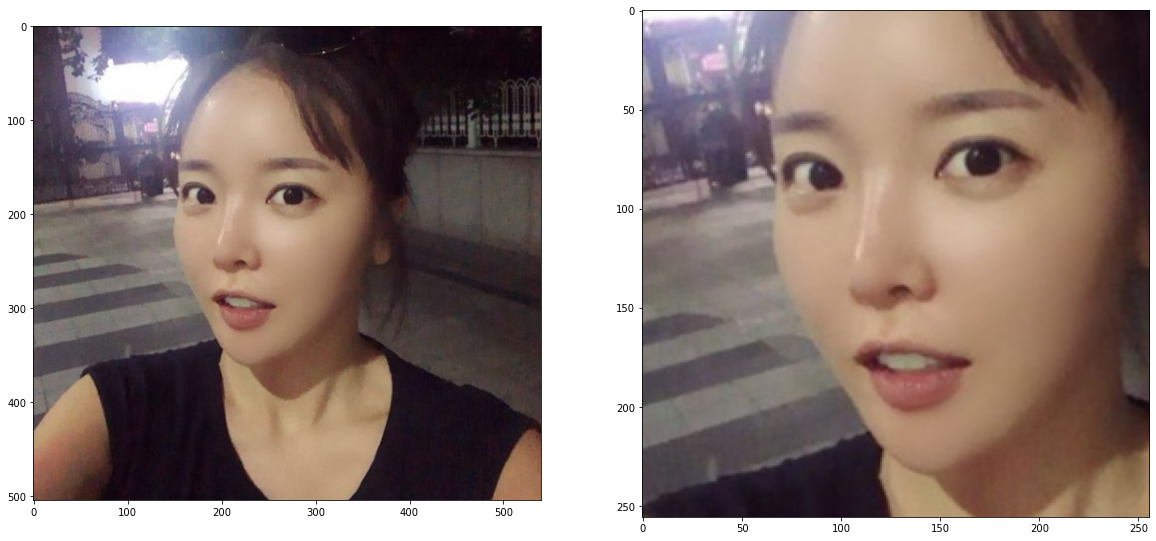

In [6]:
faces =dlib.get_face_chips(img, objs, size=256, padding=0.3) #얼굴 영역만 이미지를 잘라줌
fig, axes = plt.subplots(1,len(faces)+1,figsize=(20,16)) #한줄, subplot의 갯수, 도화지 크기 
axes[0].imshow(img) #0에 원본이미지 출력 
for i, face in enumerate(faces):
    axes[i+1].imshow(face) #얼굴이 4개인 경우 1-4번에 얼굴만 뽑아서 출력 
    

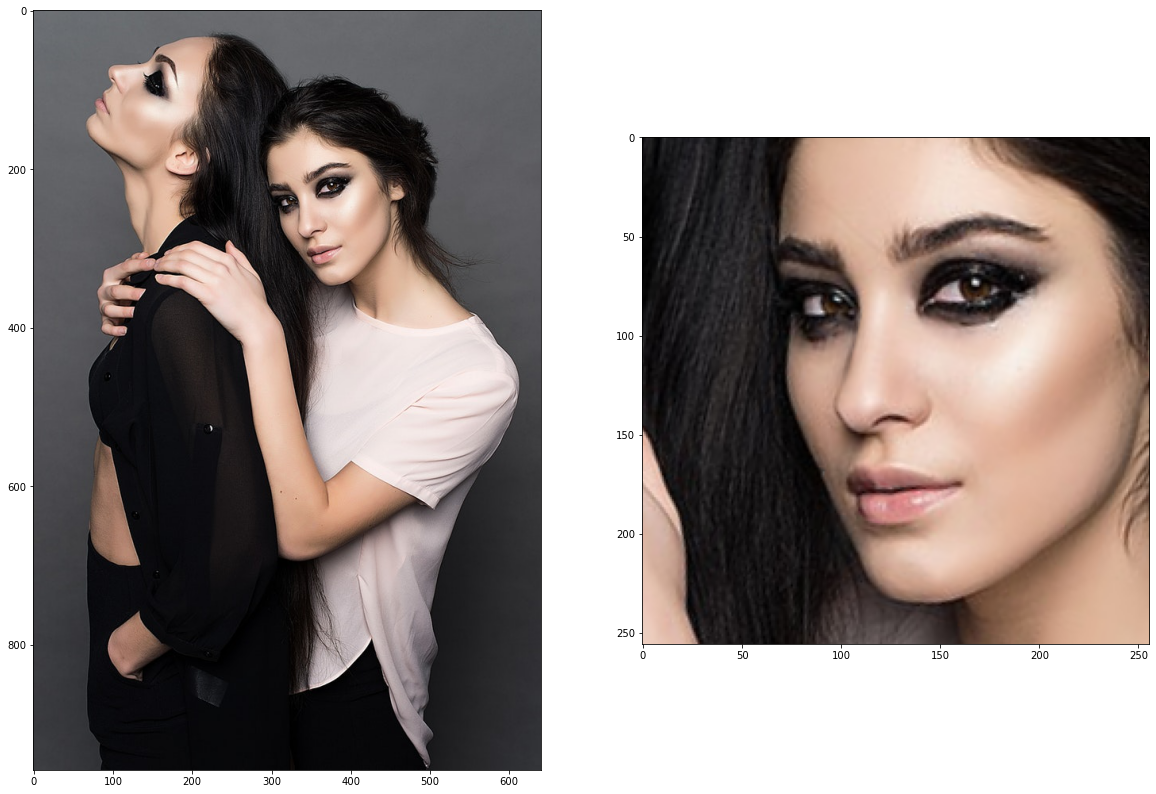

In [7]:
def align_faces(img):
    dets = detector(img, 1) #얼굴 영역을 찾아줌 -> dets 에 얼굴들이 들어가게됨  
    objs = dlib.full_object_detections() #객체를 찾아서 객체에 대한 정보를 리턴해줌. 현재는 아무것도 안줘서 비어있는 상태. 이미지의 정보를 가지고 있는 object, object의 정보(위치)를 가지고 있는 객체 (오브젝트들)
    for detection in dets: #얼굴들이 들어있음 얼굴 갯수만큼 for 문을 돌게됨 
        s = sp(img, detection) #img와 얼굴을 주면 랜드마크(점에 대한 정보)를 저장 
        objs.append(s)
    faces = dlib.get_face_chips(img, objs, size=256, padding=0.35) #얼굴 영역만 잘라서 이미지를 만들어준 것을 저장 
    #padding : 얼굴 영역 이외에 같이 출력할 여백
    return faces
test_img = dlib.load_rgb_image('./imgs/03.jpg')
test_faces = align_faces(test_img)
fig,axes = plt.subplots(1,len(test_faces)+1, figsize=(20,16))
axes[0].imshow(test_img) #가장 첫번째 supplot 에 원본 이미지 출력 
for i, face in enumerate(test_faces): #for 문을 돌면서 subplot에 얼굴이미지들을 하나씩 출력 
    axes[i+1].imshow(face)

In [8]:
sess= tf.Session()
sess.run(tf.global_variables_initializer()) #모델 초기화
saver = tf.train.import_meta_graph('./models/model.meta') #모델 불러오기 
saver.restore(sess, tf.train.latest_checkpoint('./models')) #모델 세션 초기화
graph = tf.get_default_graph()
X = graph.get_tensor_by_name('X:0')
Y = graph.get_tensor_by_name('Y:0')
XS = graph.get_tensor_by_name('generator/xs:0')

INFO:tensorflow:Restoring parameters from ./models\model


In [9]:
#https://github.com/Honlan/BeautyGAN/commit/911d2090784ff90006e988850f2f3e82c2320fc1
def preprocess(img):
    return (img / 255. - 0.5) * 2

def deprocess(img):
    return (img + 1) / 2

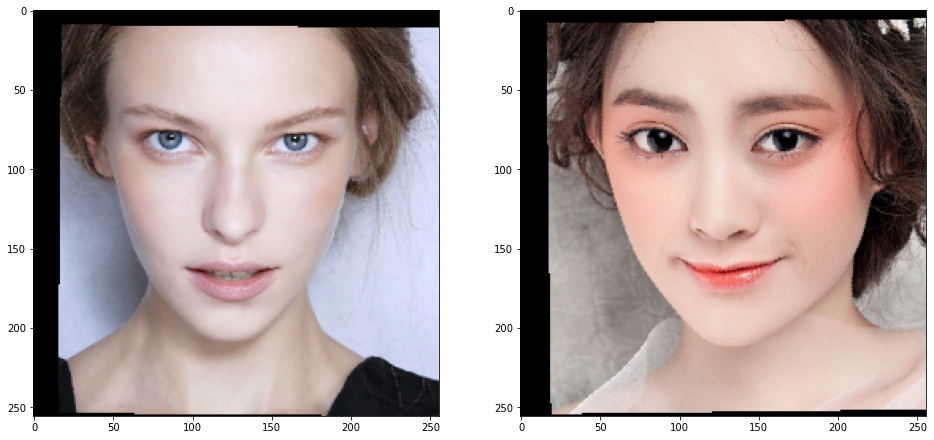

In [10]:
img1 = dlib.load_rgb_image('./imgs/no_makeup/xfsy_0068.png')
img1_faces = align_faces(img1)#소스 이미지 
img2 = dlib.load_rgb_image('./imgs/makeup/vFG112.png')#레퍼런스 이미지
img2_faces = align_faces(img2)

fig,axes = plt.subplots(1,2,figsize=(16,10))
axes[0].imshow(img1_faces[0])
axes[1].imshow(img2_faces[0])
plt.show()

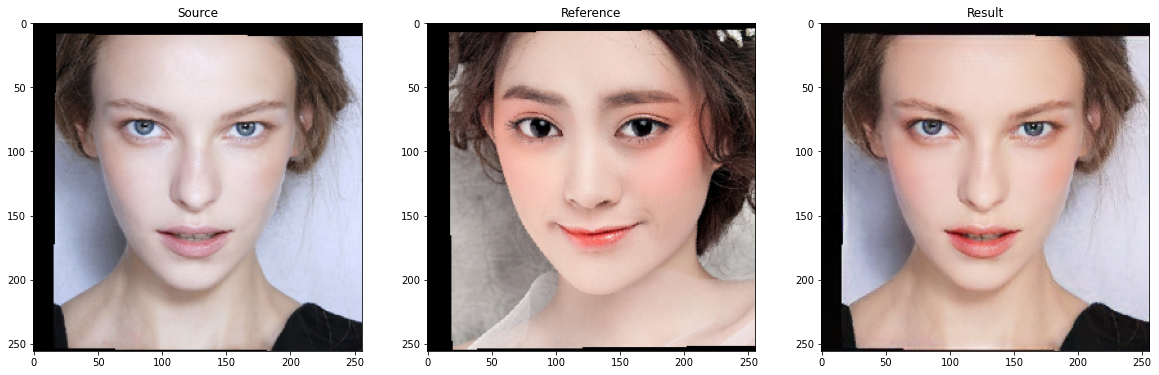

In [11]:
src_img = img1_faces[0]
ref_img = img2_faces[0]

X_img = preprocess(src_img) #스케일링
X_img = np.expand_dims(X_img, axis=0) #입력데이터로 쓰기 위해 차원 늘려주기(쉐입 맞추기) 
Y_img = preprocess(ref_img) #스케일링
Y_img = np.expand_dims(Y_img, axis=0) 

output = sess.run(XS, feed_dict={X:X_img, Y:Y_img})
output_img = deprocess(output[0])
fig, axes = plt.subplots(1,3,figsize=(20,10))
axes[0].set_title('Source')
axes[0].imshow(src_img)
axes[1].set_title('Reference')
axes[1].imshow(ref_img)
axes[2].set_title('Result')
axes[2].imshow(output_img)
#학습된 메이크업 이미지를 넣었을 때 결과가 좋음 